# Training Set Creation
Reading in QBOX simulation data and calculating features. This notebook was created to test out feature calculators, and includes plots to used when making sure that they are working. It also creates an example training set

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle as pkl
from glob import glob
from ase.io import qbox
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import LeavePGroupsOut
from stopping_power_ml.io import get_charge_density_interpolator, load_qbox_data
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from pymatgen.io.ase import AseAtomsAdaptor
from multiprocessing import Pool
from matminer.featurizers.site import AGNIFingerprints

## Load in Example Dataset
Parse a QBox output, get the particle position and force acting on it for each frame

Read all the files

In [2]:
data = []
for file in tqdm(glob('256_Al/kpg*.out')):
    try:
        frame = load_qbox_data(file)
    except Exception as exc:
        print(exc)
        continue
    frame['file'] = file
    data.append(frame)
data = pd.concat(data)
print('Read in %d training points'%len(data))

Widget Javascript not detected.  It may not be installed or enabled properly.



Read in 9800 training points


Compute the timestep

In [3]:
data.sort_values(['file_id', 'frame_id'], ascending=True, inplace=True)

In [4]:
data['timestep'] = list(range(len(data)))

In [5]:
data.set_index('timestep', inplace=True, drop=False)

Compute the displacement

In [6]:
data['displacement'] = (data['position'] - data['position'][0]).apply(np.linalg.norm)

## Plot it
Make sure nothing looks stupid wrong, and that it matches with up Andre's paper.

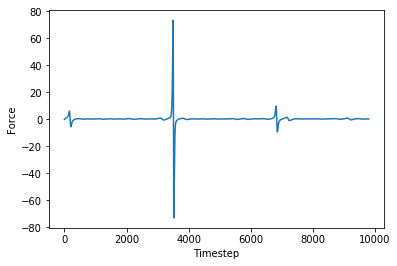

In [7]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['force'])

ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

## Determine the Start Point
These simulations have an initial transient, which should not be used to fit the model

Plot the energy. Note the peak at the beginning. This peak is due to adding the particle

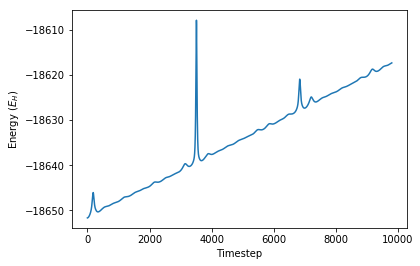

In [8]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['energy'])

ax.set_xlabel('Timestep')
ax.set_ylabel('Energy ($E_H$)')

Plot the force over the beginning. Figure out when the first peak goes away

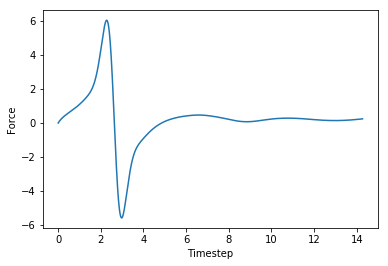

In [9]:
fig, ax = plt.subplots()

ax.plot(data['displacement'][:1000], data['force'][:1000])

ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

Remote the transient (greater than 5 should be good)

In [10]:
data.query('displacement >= 5', inplace=True)

## Compute the Density 
Get it both at the current frame and the previous

In [11]:
charge, cell = get_charge_density_interpolator(os.path.join('256_Al', 'Al_semi_core_gs.cube'))

In [12]:
charge_features = LocalChargeDensity(charge, np.linspace(1, -5, 7))

In [13]:
data = charge_features.featurize_dataframe(data, 'atoms')

Plot charge as a function of time

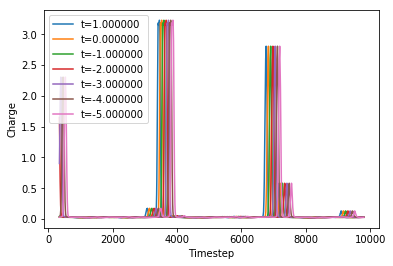

In [14]:
fig, ax = plt.subplots()

for col in charge_features.feature_labels():
    time = col.split(" ")[1]
    ax.plot(data['timestep'], data[col], label=time)

ax.legend()
    
ax.set_xlabel('Timestep')
ax.set_ylabel('Charge')

Plot the charge densities vs f

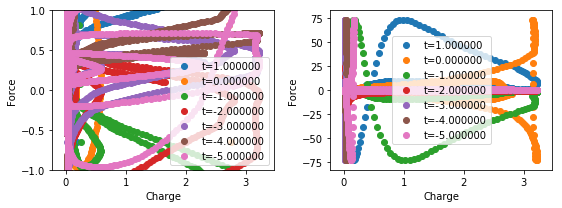

In [15]:
fig, axs = plt.subplots(1,2)

for col in charge_features.feature_labels():
    time = col.split(" ")[1]
    for ax in axs:
        ax.scatter(data[col], data['force'], label=time)

for ax in axs:
    ax.legend()

axs[0].set_ylim([-1, 1])
    
for ax in axs:
    ax.set_xlabel('Charge')
    ax.set_ylabel('Force')
    
fig.set_size_inches(8,3)
fig.tight_layout()

## Compute AGNI Fingerprints
Use these to describe the local enviroment around a particle

In [16]:
agni_features = ProjectedAGNIFingerprints(etas=np.logspace(np.log10(0.8), np.log10(16), 8))

In [17]:
data = agni_features.featurize_dataframe(data, 'atoms')

Plot them as a function of time

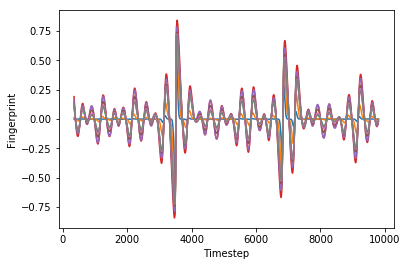

In [18]:
fig, ax = plt.subplots()

for l in agni_features.feature_labels():
    ax.plot(data['timestep'], data[l], label=l)
    
ax.set_ylabel('Fingerprint')
ax.set_xlabel('Timestep')

## Compute Ewald Forces
Get the nucleus-nucleus repulsion force acting on the particle in the direction of travel

In [19]:
ewald_features = IonIonForce(acc=2)

In [20]:
%%time
data = ewald_features.featurize_dataframe(data, 'atoms', n_jobs=None)

CPU times: user 1.88 s, sys: 307 ms, total: 2.19 s
Wall time: 12min 26s


Plot force over time

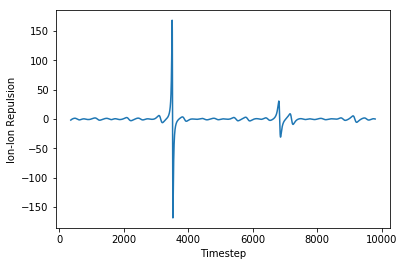

In [21]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['ion-ion repulsion'])
    
ax.set_ylabel('Ion-Ion Repulsion')
ax.set_xlabel('Timestep')

Plot the Coulomb repulsion against observed stopping force

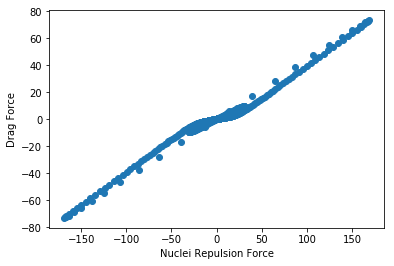

In [22]:
fig, ax = plt.subplots()

ax.scatter(data['ion-ion repulsion'], data['force'])

ax.set_xlabel('Nuclei Repulsion Force')
ax.set_ylabel('Drag Force')

## Save everything to disk
Except `Atoms` objects. Also save the featurizers

In [23]:
data.drop('atoms', axis='columns').to_csv('training_set.csv', index=False)
data.to_pickle('training_set.pkl')

In [24]:
pkl.dump([charge_features, agni_features, ewald_features], open('featurizers.pkl', 'wb'))